# Reconhecimento de Dígitos Manuscritos com Redes Neurais Convolucionais

## MNIST

## Objetivo

Este Notebook constrói, treina e aplica uma Rede Neural Convolucional para classificar dígitos manuscritos.

O objetivo é classificar uma determinada imagem de um dígito manuscrito em uma das 10 classes que representam valores inteiros de 0 a 9.

## Conjuto de dados (*Datasets*)

O MNIST ([Modified National Institute of Standards and Technology database](https://en.wikipedia.org/wiki/National_Institute_of_Standards_and_Technology)) é um grande banco de dados de dígitos manuscritos comumente utilizado para treinar vários sistemas de processamento de imagens, bem como para o treinamento e testes na área de aprendizado de máquina.

Ele foi criado pela "remistura" das amostras dos conjuntos de dados originais do NIST. Os criadores verificaram que, uma vez que o conjunto de dados de treinamento do NIST foi obtido de funcionários do American Census Bureau, enquanto o conjunto de dados de teste foi obtido de alunos do ensino médio, ele não era adequado para experimentos de aprendizado de máquina.

O MNIST é tão estudado e utilizado pela comunidade, que atua como *benchmark* para comparar o desempenho de diferentes algoritmos de reconhecimento de imagens.

* #### **Dados de treino**: 60.000 imagens 
Utilizado para criar o modelo preditivo/classificador

* #### **Dados de teste**: 10.000 imagens 
Utilizado para avaliar o modelo durante o treinamento

* #### Imagens quadradas (pequenas) em escala (níveis) de cinza de 28 × 28 pixels

*Fonte dos dados:*http://yann.lecun.com/exdb/mnist/

*Referência:* https://en.wikipedia.org/wiki/MNIST_database)

*LeNet-5:* http://yann.lecun.com/exdb/lenet/index.html

*Algumas imagens do MNIST:*

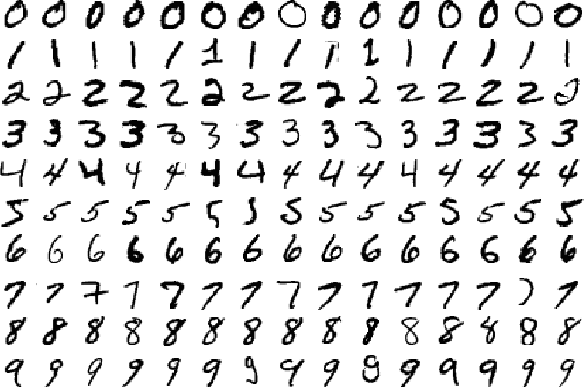


## Habilitando GPU

In [9]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Carregando os dados

In [20]:
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(trainX, trainY), (testX, testY) = mnist.load_data()
print('Dados de treino: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Dados de teste: X=%s, y=%s' % (testX.shape, testY.shape))

Dados de treino: X=(60000, 28, 28), y=(60000,)
Dados de teste: X=(10000, 28, 28), y=(10000,)


Abaixo seguem visualizações de algumas imagens do conjunto de dados de treinamento (dataset_treino).

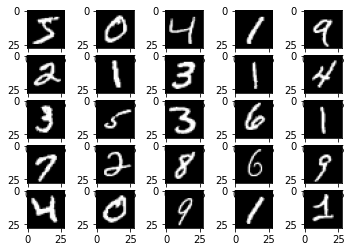

In [21]:
from matplotlib import pyplot
for i in range(25):
	# define subplot
	pyplot.subplot(5,5,i+1)
	# imprime os dados (imagens) 
	pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# mostra a figura
pyplot.show()

Uma vez que as imagens estão em tons de cinza podemos remodelar as matrizes de dados para ter um **único canal de cor**,  deixando então os dados de entrada no formato tensor 4D (padrão da camada convolucional [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) do Keras).

In [4]:
trainX = trainX.reshape((60000, 28, 28, 1))
testX = testX.reshape((10000, 28, 28, 1))

## Normalizando os dados

Sabemos que os valores de pixel para cada imagem no conjunto de dados são inteiros sem sinal no intervalo entre preto e branco, ou 0 e 255.

Normalizamos então os valores o intervalo [0,1]. Isso envolve primeiro a conversão do tipo de dados de inteiros sem sinal em flutuantes e, em seguida, a divisão dos valores de pixel pelo valor máximo.

In [22]:
trainX = trainX.astype('float32') / 255
testX = testX.astype('float32') / 255

## *OneHotEncoder*

Sabemos que são 10 classes (rótulos) e que as classes são representadas como inteiros únicos.

Podemos então usar uma codificação para a classe de cada amostra, transformando o inteiro em um vetor binário de 10 elementos com 1 para o índice do valor da classe e 0 valores para todas as outras classes. Podemos fazer isso com a função to_categorical().

In [23]:
trainY = to_categorical(trainY)
testY = to_categorical(testY)

## Construção da Rede Neural Convolucional

Utilizamos o modelo sequencial oferecido pelo Keras para montarmos as camadas de nossa rede neural convolucional. Lembrando que o Keras utiliza o TensorFlow como backend. Na verdade, o Keras é apenas uma biblioteca para simplificar a complexidade do TensorFlow. 

Dado que o problema é uma tarefa de classificação multiclasse, teremos então uma **camada de saída com 10 nós** para prever a distribuição de probabilidade de uma imagem pertencente a cada uma das 10 classes. Isso também requer a **função de ativação softmax**.

Todas as outras camadas usarão a **função de ativação ReLU** e a estratégia de **inicialização de pesos He** (melhores recomendações para esses parâmetros).

Entre a camada de extração de atributos (camada de convolução) e a camada de saída, utiliza-se uma camada densa (**full conection**) para interpretar os atributos/características, neste caso com 100 nós.

Características particulares dessa versão:
 
* **01 Camada Convolucional** para a *extração de atributos* com um tamanho de filtro pequeno (3,3) e um número modesto de filtros (32) seguido por uma camada de pooling (máximo);
* **01 Camada Convolucional** com 64 filtros (3,3) seguido por uma camada de pooling (máximo);
* Dropout de 25% depois de cada camada da rede (seja convolucional ou densa)


In [24]:
# Importação dos pacotes
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense

# Inicializando a Rede Neural Convolucional
model = Sequential()
# 1a. Camada de Convolução (aplicando 32 filtros 3x3, função de ativação Relu, inicialização de pesos He e dimensionando as entradas para o formato 28x28x1)
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
# Pooling 2x2 (para reduzir os tamanhos dos mapas de atributos resultantes da 1a. camada de convolução)
model.add(MaxPooling2D((2, 2)))
# Dropout 25%
model.add(Dropout(0.25))
# 2a. Camada de Convolução (aplicando 64 filtros 3x3, função de ativação Relu, inicialização de pesos He)
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
# Pooling 2x2 (para reduzir os tamanhos dos mapas de atributos resultantes da 2a. camada de convolução)
model.add(MaxPooling2D((2, 2)))
# Dropout 25%
model.add(Dropout(0.25))
# Flattening (para converter a estrutura de dados da camada anterior em um vetor)
model.add(Flatten())
# Camada Full connection (100 neurônios com função de ativação Relu e inicialização de pesos HE)
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
# Dropout 25%
model.add(Dropout(0.25))
# Camada de saída com 10 neurônios (10 classes!) e função de ativação softmax (multiclasse)
model.add(Dense(10, activation='softmax'))

### Sumário da arquitetura da rede neural convolucional

Execute o comando abaixo para obter um resumo da arquitetura da rede neural convolucional construída e para ver também o número de parâmetros da mesma.

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)          0

Compilação da Rede Neural Convolucional

Esta versão utiliza uma configuração conservadora para o otimizador: **gradiente estocástico com uma taxa de aprendizado de 0,01 e um momentum de 0,9**.

A função de perda (função de erro): **entropia cruzada categórica** adequada para classificação multiclasse

E a métrica de desempenho 'accuracy' (proporção de casos corretamente previstos).

In [29]:
from tensorflow.keras.optimizers import SGD
# Compilando a rede
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## Treinamento da Rede Neural Convolucional
Uma vez construída (montada) a arquitetura da rede neural, o próximo passo é o **treinamento**.

In [30]:
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY))

Epoch 1/10
1875/1875 [==============================] - 18s 4ms/step - loss: 0.2402 - accuracy: 0.9256 - val_loss: 0.0483 - val_accuracy: 0.9842
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0969 - accuracy: 0.9702 - val_loss: 0.0381 - val_accuracy: 0.9868
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0750 - accuracy: 0.9770 - val_loss: 0.0339 - val_accuracy: 0.9884
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0619 - accuracy: 0.9808 - val_loss: 0.0303 - val_accuracy: 0.9902
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0565 - accuracy: 0.9823 - val_loss: 0.0320 - val_accuracy: 0.9881
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0498 - accuracy: 0.9845 - val_loss: 0.0245 - val_accuracy: 0.9914
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0462 - accuracy: 0.9858 - val_loss: 0.0258 - val_accuracy

## Análise da função *loss* (erro/perda)
Vamos observar o comportamento da função *loss* para os dados de treino e de validação.

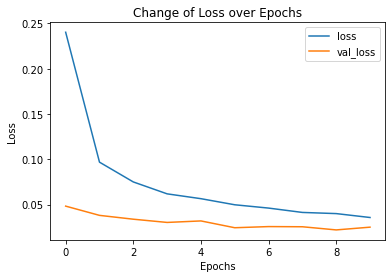

In [31]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.title('Change of Loss over Epochs')
plt.legend(['loss', 'val_loss'])
plt.show()

## Análise da métrica de desempenho (acurácia)
Vamos observar o desempenho (acurácia) da rede para os dados de treino e de validação.

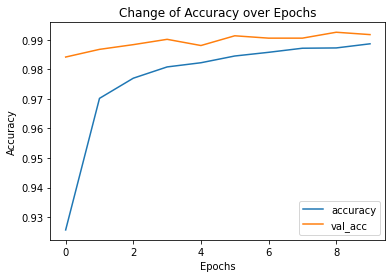

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.title('Change of Accuracy over Epochs')
plt.legend(['accuracy', 'val_acc'])
plt.show()

## Teste da rede neural treinada (fazendo predições)

Após o treinamento da rede, vamos realizar alguns testes com imagens geradas manualmente que não fazem parte dos dados originais de treino e teste.

Cada imagem a ser testada deve ser redimensionada para o formato utilizado no treinamento da rede neural (28x28) e convertida para um array.

Carregamento da imagem teste

In [33]:
from google.colab import files
uploaded = files.upload()

Saving 2.jpg to 2 (1).jpg


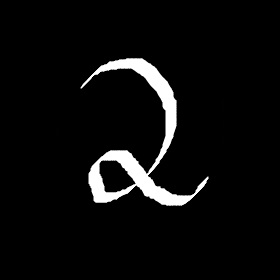

[2] 




In [34]:
import numpy as np
from keras.preprocessing import image
from IPython.display import display, Image

file_name = '2.jpg'
imagem_teste = image.load_img(file_name, color_mode = "grayscale", target_size = (28, 28))
imagem_teste = image.img_to_array(imagem_teste)
# redimensiona para um canal
imagem_teste = imagem_teste.reshape(1, 28, 28, 1)
# prepara os pixels
imagem_teste = imagem_teste.astype('float32')
imagem_teste = imagem_teste/255.0
# predição do modelo 
predicao = np.argmax(model.predict(imagem_teste), axis=-1) 
# exibe a imagem teste     
display(Image(file_name)) 
print(predicao,'\n\n')          

## Referências (artigos) para melhorar o desempenho:

Who is the best in MNIST?
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354
